# Customer Segmentation - Preprocessing and Training

This notebook will be used to prepare the data set for clsutering and to create a baseline clustering model. All data cleaning was done in [this](https://github.com/NickD-Dean/Springboard/blob/ce7358bfc84ceee14d287000eb132e8ff06a944b/Capstone%20Project%203/Code/03%20-%20Customer%20Segmentation%20Data%20Wrangling.ipynb) notebook, and exploratory analysis can be found [here](https://github.com/NickD-Dean/Springboard/blob/ce7358bfc84ceee14d287000eb132e8ff06a944b/Capstone%20Project%203/Code/04%20-%20Exploratory%20Data%20Analysis.ipynb)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from sklearn.decomposition import PCA
import matplotlib.colors
from scipy import stats
%matplotlib inline
# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [3]:
data = pd.read_parquet('../Data/Trimmed_Data')

In [4]:
data.head()

,Age,Marital_status,Income,Homeowner_status,Household_comp,Household_size,Kids,CampaignsRedeemed,CampaignsSent,Percent_CampaignRedeemed,...,Num_stores_visited,Most_freq_store,Most_freq_time,First_active_day,Last_active_day,Recency,Frequency,Monetary,Avg_trips_week,Avg_shopping_lag
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,2,8,0.25,...,2,436.0,1456.0,51,706,5,0.120956,4330.16,1.264706,7.705882
7,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,0,4,0.00,...,2,359.0,1711.0,23,709,2,0.082982,3400.05,1.180000,11.827586
8,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,1,10,0.10,...,3,321.0,2149.0,65,706,5,0.158931,5534.97,1.569444,5.723214
13,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,7,10,0.70,...,1,323.0,1130.0,101,709,2,0.386779,13190.92,3.160920,2.218978
16,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,0,2,0.00,...,2,3316.0,657.0,98,690,21,0.137834,1512.02,1.689655,6.103093


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 801 entries, 1 to 2499
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            801 non-null    object 
 1   Marital_status                 801 non-null    object 
 2   Income                         801 non-null    object 
 3   Homeowner_status               801 non-null    object 
 4   Household_comp                 801 non-null    object 
 5   Household_size                 801 non-null    object 
 6   Kids                           801 non-null    object 
 7   CampaignsRedeemed              801 non-null    int64  
 8   CampaignsSent                  801 non-null    int64  
 9   Percent_CampaignRedeemed       801 non-null    float64
 10  CouponRedeemed_Count           801 non-null    int64  
 11  CouponSent_Count               801 non-null    int64  
 12  Percent_CouponsRedeemed        801 non-null    fl

### Pre-processing steps:

1. I need to remove colinear features as identified in the previous EDA notebook. 

2. Remove categorical data, and one-hot encode this information. 

3. Remove outliers from the data set (I'll initially remove values which lie outside 3 standard deviations of the mean.)

4. Standardize skewed features using a log transform. (Ultimately decided against, with so many values of 'zero' in the data set it caused issues when transforming back into the original form for analysis)

5. Scale all numerical features using the MinMaxScaler to shift all data onto the same scale as one-hot encoded data.

#### Removing colinear features

In [6]:
# In the previous notebook I created a data frame that logged if features pairwise correlations were 'high', 'mid', 
# or 'low'.  I'll use this as a reference later on to determine if additional features should be dropped.

data = data.drop(['%_baskets_product_mailer', '%_baskets_product_displayed', 'Last_active_day'], axis=1)
idx = data.index
s3 = set(idx)

#### Separating out categorical data and one-hot encoding this data

In [7]:
cat = data.select_dtypes(exclude=np.number)

In [8]:
# This does not include certain categories which ARE categorical but are not strings at this time
# I need to include most frequent store, most/least frequent product, high volume propduct, and most frequent time
cat.head()

,Age,Marital_status,Income,Homeowner_status,Household_comp,Household_size,Kids,Most_freq_dept,Least_freq_dept,Most_freq_product,Least_freq_product,High_volume_product,Most_freq_store,Most_freq_time
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,GROCERY,FLORAL,825123.0,1051883.0,856942.0,436.0,1456.0
7,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,GROCERY,FLORAL,865569.0,1102439.0,1022003.0,359.0,1711.0
8,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,GROCERY,DAIRY DELI,824550.0,13006897.0,6534178.0,321.0,2149.0
13,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,GROCERY,AUTOMOTIVE,1106523.0,1133378.0,6534178.0,323.0,1130.0
16,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,GROCERY,SALAD BAR,2378842.0,2455285.0,6410462.0,3316.0,657.0


In [9]:
Age = pd.get_dummies(cat.Age, drop_first=True, prefix='Age')
Marital = pd.get_dummies(cat.Marital_status, drop_first=True, prefix='Marital')
Income = pd.get_dummies(cat.Income, drop_first=True, prefix='Income')
Home = pd.get_dummies(cat.Homeowner_status, drop_first=True, prefix='Home')
Comp = pd.get_dummies(cat.Household_comp, drop_first=True, prefix='Composition')
Size = pd.get_dummies(cat.Household_size, drop_first=True, prefix='Size')
Kids = pd.get_dummies(cat.Kids, drop_first=True, prefix='Kids')
Freq = pd.get_dummies(cat.Most_freq_dept, drop_first=True, prefix='Freq_dept')
Least = pd.get_dummies(cat.Least_freq_dept, drop_first=True, prefix='Least_dept')
F_prod = pd.get_dummies(cat.Most_freq_product, drop_first=True, prefix='Freq_prod')
L_prod = pd.get_dummies(cat.Least_freq_product, drop_first=True, prefix='Least_prod')
H_prod = pd.get_dummies(cat.High_volume_product, drop_first=True, prefix='HV_prod')
F_store = pd.get_dummies(cat.Most_freq_store, drop_first=True, prefix='Freq_store')
F_time = pd.get_dummies(cat.Most_freq_time, drop_first=True, prefix='Freq_time')

Dummy = pd.concat([Age, Marital, Income, Home, Comp, Size, Kids, Freq, Least, F_prod, L_prod, H_prod, F_store, F_time]
                 , axis=1)
Dummy.shape

(801, 1790)

Clearly creating dummy variables for all of the categorical variables is going to create a problem when it comes to dimensionality.  I need to determine which of these categories to drop. 

Immediately as an option is the time shoppers most frequently purchase in.  This can be 'binned' to significantly fewer categories (morning, afternoon, evening).  

Additionally, it's unlikely that I need both High volume, Most frequently purchased, and Least frequently purchased products as variables.  I'll drop two of those three options. Similarly I'll drop either the Most or Least frequent department purchased from.

I'll make this decision based on the amount of dimensions that are created for each feature. 

In [10]:
cat.nunique()

Age                      6
Marital_status           3
Income                  12
Homeowner_status         5
Household_comp           6
Household_size           5
Kids                     4
Most_freq_dept           4
Least_freq_dept         31
Most_freq_product      606
Least_freq_product     318
High_volume_product    157
Most_freq_store        115
Most_freq_time         532
dtype: int64

In [11]:
# Based on the above if I drop the features with the most unique values from the options above I'll be left with a
# dummy data frame with 309 dimensions instead of 1790. 

Time = cat.Most_freq_time

Time = Time.astype('float')
Time = Time.astype('int')
# Define function to map to the Time series

def himidlow(x):
    if x < 1200: return 'Morning'
    elif x >= 1200 and x < 1700: return 'Afternoon'
    elif x >= 1700: return 'Evening'
    
Time = Time.map(himidlow)
Time = pd.get_dummies(Time, drop_first=True, prefix='Shopping_time')

In [12]:
Dummy = pd.concat([Age, Marital, Income, Home, Comp, Size, Kids, Freq, H_prod, F_store, Time], axis=1)
Dummy.shape

(801, 309)

#### Handling Outliers

I've created a dataframe for the categorical information, next up is time to remove outliers from the numerical data.

In [13]:
num = data.select_dtypes(include = np.number)
num

,CampaignsRedeemed,CampaignsSent,Percent_CampaignRedeemed,CouponRedeemed_Count,CouponSent_Count,Percent_CouponsRedeemed,TypeA,TypeB,TypeC,PercentTypeA,...,Avg_loyalty_disc,Max_loyalty_disc,Min_loyalty_disc,Num_stores_visited,First_active_day,Recency,Frequency,Monetary,Avg_trips_week,Avg_shopping_lag
1,2,8,0.25,5,662,0.007553,3.0,4.0,1.0,0.375,...,-8.105116,0.00,-23.30,2,51,5,0.120956,4330.16,1.264706,7.705882
7,0,4,0.00,0,251,0.000000,1.0,3.0,0.0,0.250,...,-8.178136,0.00,-33.57,2,23,2,0.082982,3400.05,1.180000,11.827586
8,1,10,0.10,1,669,0.001495,3.0,7.0,0.0,0.300,...,-9.542478,0.00,-54.69,3,65,5,0.158931,5534.97,1.569444,5.723214
13,7,10,0.70,21,668,0.031437,3.0,6.0,1.0,0.300,...,-5.917055,0.00,-34.72,1,101,2,0.386779,13190.92,3.160920,2.218978
16,0,2,0.00,0,221,0.000000,1.0,1.0,0.0,0.500,...,-1.747857,0.00,-11.24,2,98,21,0.137834,1512.02,1.689655,6.103093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,1,2,0.50,5,227,0.022026,1.0,1.0,0.0,0.500,...,-12.628000,-0.01,-50.03,7,114,9,0.049226,2120.93,1.346154,17.294118
2496,3,5,0.60,11,612,0.017974,3.0,1.0,1.0,0.600,...,-17.699841,0.00,-49.58,3,117,28,0.088608,4339.66,1.312500,9.129032
2497,0,3,0.00,0,574,0.000000,3.0,0.0,0.0,1.000,...,-6.068009,0.00,-68.21,12,78,11,0.310830,7111.98,2.569767,2.827273
2498,0,6,0.00,0,600,0.000000,3.0,2.0,1.0,0.500,...,-1.624419,0.00,-28.26,7,105,1,0.241913,2601.60,2.567164,3.538012


In [14]:
# Removing outliers which are 3 standard deviations from the mean of each feature
z_scores = np.abs(stats.zscore(num))
outliers_threshold = 3  
mask = (z_scores <= outliers_threshold).all(axis=1)
NUM = num[mask]
NUM.head()

,CampaignsRedeemed,CampaignsSent,Percent_CampaignRedeemed,CouponRedeemed_Count,CouponSent_Count,Percent_CouponsRedeemed,TypeA,TypeB,TypeC,PercentTypeA,...,Avg_loyalty_disc,Max_loyalty_disc,Min_loyalty_disc,Num_stores_visited,First_active_day,Recency,Frequency,Monetary,Avg_trips_week,Avg_shopping_lag
1,2,8,0.25,5,662,0.007553,3.0,4.0,1.0,0.375,...,-8.105116,0.0,-23.30,2,51,5,0.120956,4330.16,1.264706,7.705882
7,0,4,0.00,0,251,0.000000,1.0,3.0,0.0,0.250,...,-8.178136,0.0,-33.57,2,23,2,0.082982,3400.05,1.180000,11.827586
8,1,10,0.10,1,669,0.001495,3.0,7.0,0.0,0.300,...,-9.542478,0.0,-54.69,3,65,5,0.158931,5534.97,1.569444,5.723214
16,0,2,0.00,0,221,0.000000,1.0,1.0,0.0,0.500,...,-1.747857,0.0,-11.24,2,98,21,0.137834,1512.02,1.689655,6.103093
17,0,5,0.00,0,866,0.000000,5.0,0.0,0.0,1.000,...,-8.948065,0.0,-63.78,4,24,22,0.174402,5139.63,1.907692,5.406504


This resulted in far fewer columns, which indicates that there is likely a cluster of consumers who are 'high end' - these are more than likely the 'corporate' customers I mentioned in a previous notebook. I'm going to move forward WITHOUT removing outliers and 'throw the kitchen sink' at the clustering algorithm, I can compare the silhouette scores with and without outliers to see if there are more patterns that appear. 

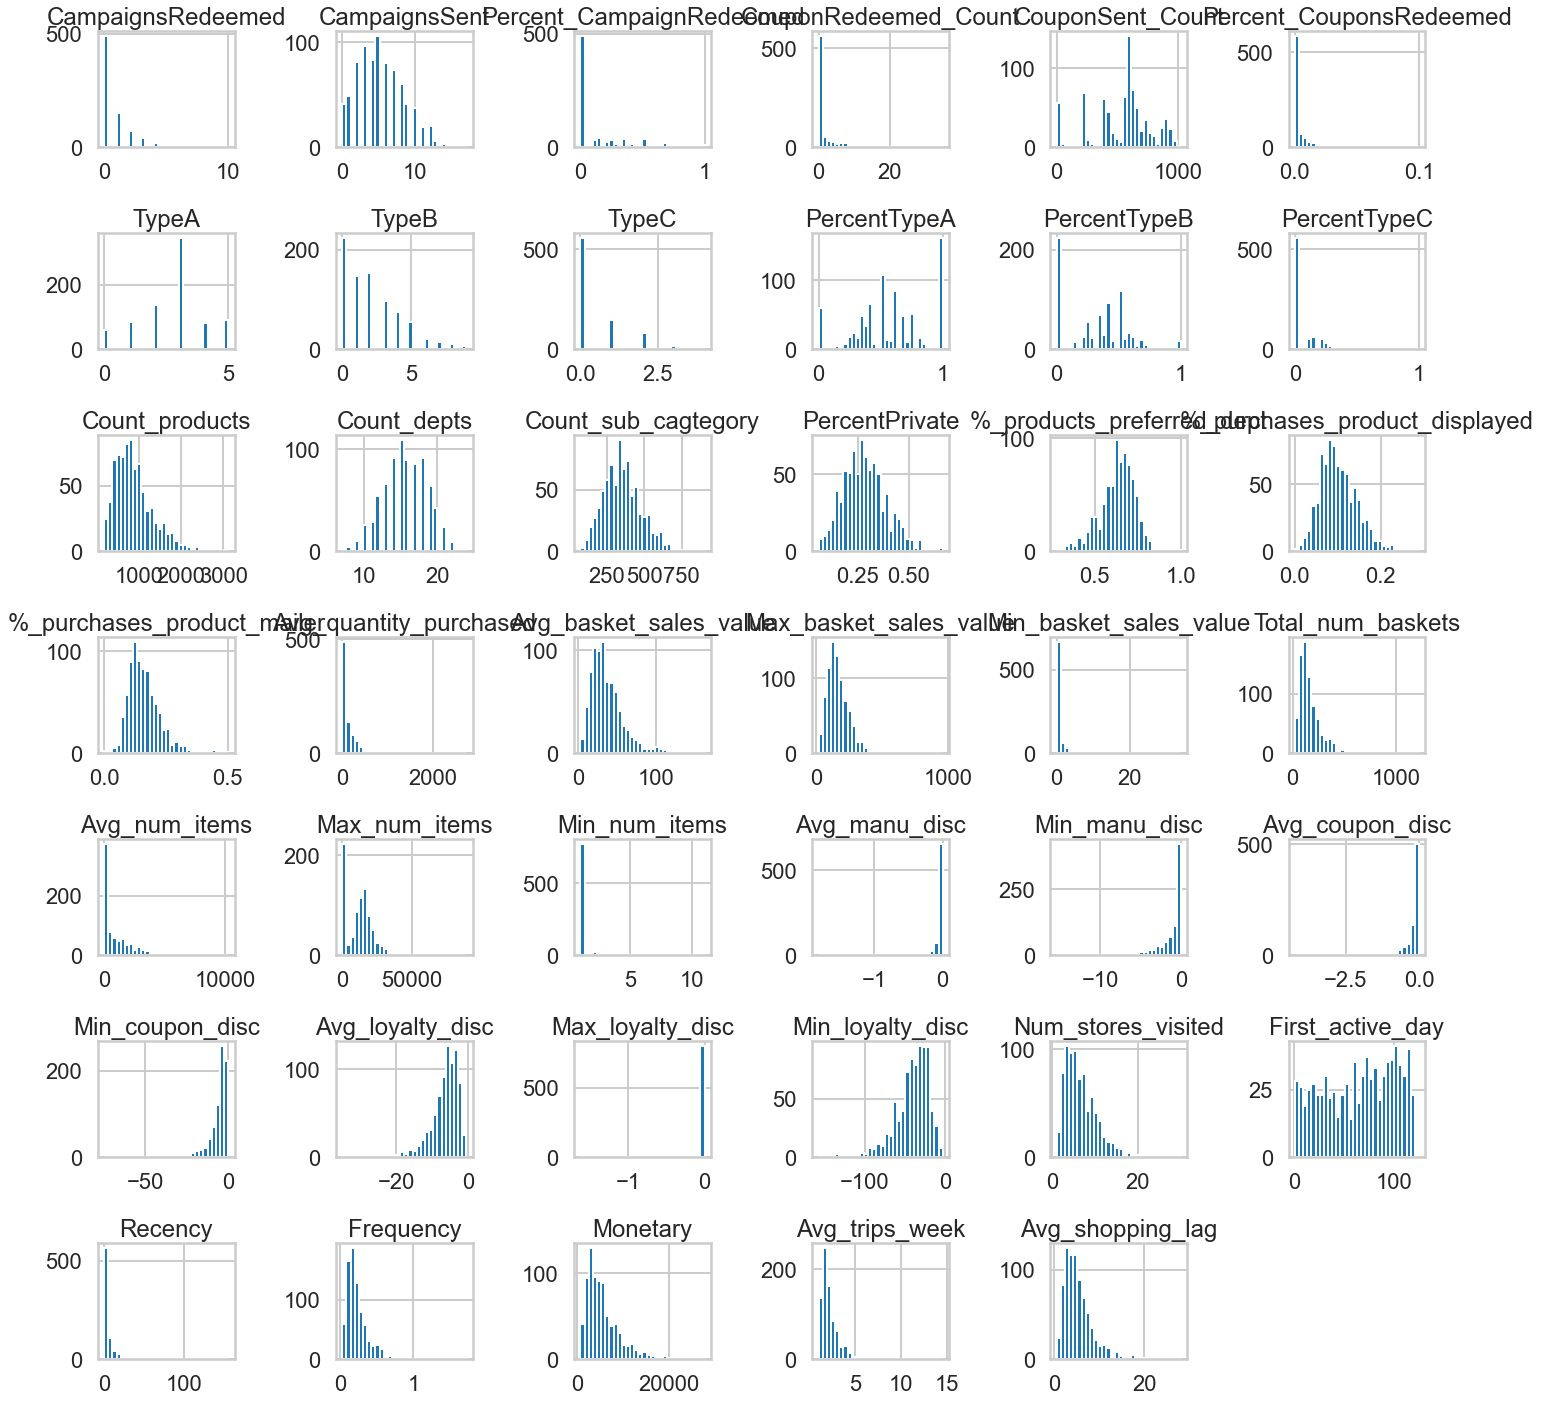

In [15]:
# Next I need to check and see if there are any issues with skewed data that would indicate a need for a log 
# transformation
num.hist(bins=30, figsize=(20,20))
plt.tight_layout()

In [16]:
num.head()
cols = list(num.columns)

In [17]:
# There is some definite skew
num = num.applymap(np.abs)
scaler = MinMaxScaler()
scaler.fit(num)
num = scaler.transform(num)
num = pd.DataFrame(num, columns=cols, index=idx)

Now that the data set has been prepared for clustering analysis, it's time to instantiate the clustering model and get some initial results.

### Building initial clustering model

I'm going to build and fit a kmeans model to the data set and see what initial results provide as a baseline.

In [18]:
# Combining both dataframes together
new = pd.concat([num,Dummy], axis=1)
k = KMeans(random_state=42)
k.fit(new)

KMeans(random_state=42)

In [19]:
label = k.labels_
len(label)

801

In [20]:
new['Labels'] = label